In [55]:
import pandas as pd
import sidetable
import ast
import numpy as np
# pd.set_option('display.max_rows', None)
import re
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.float_format', lambda x: '%.2f' % x)
import datetime as dt

In [56]:
df = pd.read_csv("../Data/merged_dataset.csv")

In [57]:
df.head(2)

,id,typeId,subtypeId,date,advertiser,descriptions,region,province,city,zipcode,latitude,longitude,rooms,bathrooms,surface,energy_certificate,antiquity,floor,surfaceland,price
0,162758656,2,1,2022-02-24T20:14:25.657,NOVACASA ALBACETE INMOBILIARIA,{'es-ES': 'NovaCasa VENDE Piso de 5 Dormitorio...,Castilla-La Mancha,Albacete,Albacete Capital,2004,38.99,-1.87,5,2,140,7,6,0,0,135000.00
1,162463749,2,1,2022-01-31T08:06:16.413,Haya Real Estate,"{'es-ES': 'Edificio de 4 plantas, con fachada ...",Castilla-La Mancha,Albacete,Albacete Capital,2005,39.00,-1.86,3,2,1,7,0,9,0,77328.00


In [58]:
df.shape

(228116, 20)

In [59]:
df.dtypes

id                      int64
typeId                  int64
subtypeId               int64
date                   object
advertiser             object
descriptions           object
region                 object
province               object
city                   object
zipcode                object
latitude              float64
longitude             float64
rooms                   int64
bathrooms               int64
surface                 int64
energy_certificate      int64
antiquity               int64
floor                   int64
surfaceland             int64
price                 float64
dtype: object

In [60]:
# df.isnull().sum()
df.stb.missing().head(6)

,missing,total,percent
advertiser,16695,228116,7.32
price,3055,228116,1.34
city,16,228116,0.01
zipcode,15,228116,0.01
rooms,0,228116,0.00
surfaceland,0,228116,0.00


In [61]:
# drop column
df.drop('typeId', axis=1, inplace=True)

In [91]:
# buscar los diferentes tipos ¿¿¿¿¿??????
df['subtypeId'].replace({55: 5, 52: 5, 0: 9, 54: 8}, inplace= True)
subtype_name = {1: "Piso", 3: "Chalet", 5: "Casa adosada", 2: "Apartamento", 7: "Duplex", 6 : "Atico", 9 : "Finca", 8 : "Estudio o loft"}
df['subtypeId'] = df['subtypeId'].map(subtype_name)

In [63]:
# column descriptions
df['descriptions'] = df['descriptions'].apply(lambda dict: ast.literal_eval(dict))
df['descriptions'] = df['descriptions'].apply(lambda x: x.setdefault('es-ES', np.nan))

In [64]:
def extract_cp(i):
    try:
        i = str(i)
        if type(i) == str:
            i = re.findall(r'^\d*', i)[0].lstrip("0")
            if len(i) > 3:
                return i
            else:
                return np.nan
    except:
        return np.nan

df['zipcode'] = df['zipcode'].apply(extract_cp)
df['zipcode'] = df.groupby(['city'])['zipcode'].apply(lambda x: x.fillna(x.mode()[0]) if x.mode().empty == False else x.fillna(np.nan))
df = df.dropna(subset=["zipcode"])
df['zipcode'] = df['zipcode'].astype('category')

In [65]:
# formato fecha y hora        
df['date'] = pd.to_datetime(df['date'])
df = df[df['date'] > '2021']
df['date'] = df['date'].astype("category") 

In [66]:
df.isnull().sum()

id                        0
subtypeId                 0
date                      0
advertiser            10611
descriptions           3264
region                    0
province                  0
city                      0
zipcode                   0
latitude                  0
longitude                 0
rooms                     0
bathrooms                 0
surface                   0
energy_certificate        0
antiquity                 0
floor                     0
surfaceland               0
price                  1949
dtype: int64

In [67]:
df = df.dropna(subset=["price"])
df['price'] = df['price'].astype('int64')

In [68]:
df.dtypes

id                       int64
subtypeId                int64
date                  category
advertiser              object
descriptions            object
region                  object
province                object
city                    object
zipcode               category
latitude               float64
longitude              float64
rooms                    int64
bathrooms                int64
surface                  int64
energy_certificate       int64
antiquity                int64
floor                    int64
surfaceland              int64
price                    int64
dtype: object

## Outliers

In [69]:
df_num = df.select_dtypes(['int'])

In [70]:
df_num.describe()

,id,subtypeId,rooms,bathrooms,surface,energy_certificate,antiquity,floor,surfaceland,price
count,170987.00,170987.00,170987.00,170987.00,170987.00,170987.00,170987.00,170987.00,170987.00,170987.00
mean,161625346.01,3.65,3.14,1.92,455.31,6.07,2.81,3.12,22610.25,259426.44
std,1261403.31,7.83,2.86,11.02,30632.99,1.74,2.99,3.88,3793800.76,944795.49
min,158370749.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,10000.00
25%,160769226.00,1.00,2.00,1.00,80.00,5.00,0.00,0.00,0.00,89900.00
50%,161983863.00,2.00,3.00,2.00,106.00,7.00,1.00,0.00,0.00,150000.00
75%,162698955.00,3.00,4.00,2.00,170.00,7.00,6.00,7.00,0.00,260000.00
max,163109333.00,55.00,999.00,2002.00,8050000.00,7.00,9.00,21.00,676522043.00,235000000.00


In [71]:
df = df[(df['rooms'] > 0) & (df['rooms'] < 8)]
df = df[(df['bathrooms'] > 0) & (df['bathrooms'] < 5)]
df = df[(df['surface'] > 30) & (df['surface'] < 600)]
df = df[df['floor'] < 12]
df = df[df['surfaceland'] < 2500]
df = df[(df['price'] > 20000) & (df['price'] < 900000)]

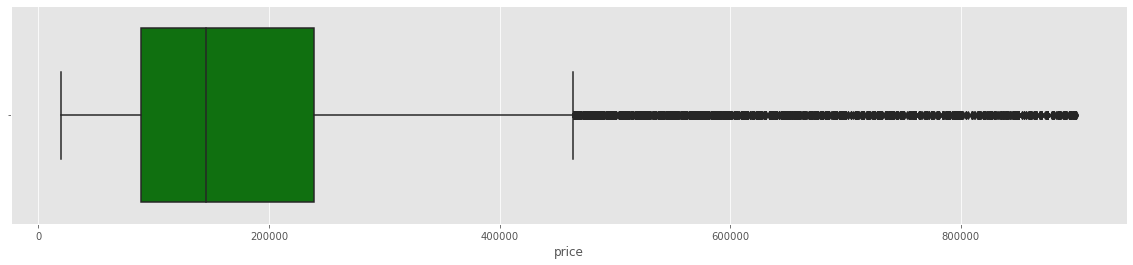

In [72]:
plt.rcParams["figure.figsize"] = (20,4)
plt.style.use("ggplot")

sns.boxplot(data = df, x = 'price', color= 'green')

plt.show();

In [73]:
df.describe()

,id,subtypeId,latitude,longitude,rooms,bathrooms,surface,energy_certificate,antiquity,floor,surfaceland,price
count,149281.00,149281.00,149281.00,149281.00,149281.00,149281.00,149281.00,149281.00,149281.00,149281.00,149281.00,149281.00
mean,161633200.38,3.43,39.43,-3.66,3.06,1.76,129.75,6.08,2.86,3.14,12.76,188790.22
std,1255813.77,7.52,3.47,4.09,1.09,0.76,80.26,1.71,2.97,3.69,112.05,148017.85
min,158370749.00,0.00,0.00,-18.09,1.00,1.00,31.00,0.00,0.00,0.00,0.00,20009.00
25%,160786717.00,1.00,37.74,-5.65,2.00,1.00,80.00,5.00,0.00,0.00,0.00,89000.00
50%,161989264.00,1.00,39.91,-3.64,3.00,2.00,102.00,7.00,3.00,0.00,0.00,145000.00
75%,162700169.00,3.00,41.95,-0.80,4.00,2.00,150.00,7.00,6.00,7.00,0.00,239000.00
max,163109333.00,55.00,43.77,4.30,7.00,4.00,599.00,7.00,9.00,11.00,2472.00,899950.00


In [95]:
df.stb.freq(["subtypeId"])

,subtypeId,count,percent,cumulative_count,cumulative_percent
0,Piso,79662,53.36,79662,53.36
1,Chalet,30622,20.51,110284,73.88
2,Casa adosada,15874,10.63,126158,84.51
3,Apartamento,10695,7.16,136853,91.67
4,Duplex,4455,2.98,141308,94.66
5,Atico,4282,2.87,145590,97.53
6,Finca,3269,2.19,148859,99.72
7,Estudio o loft,422,0.28,149281,100.00


In [96]:
df.head(1)

,id,subtypeId,date,advertiser,descriptions,region,province,city,zipcode,latitude,longitude,rooms,bathrooms,surface,energy_certificate,antiquity,floor,surfaceland,price
0,162758656,Piso,2022-02-24 20:14:25.657,NOVACASA ALBACETE INMOBILIARIA,NovaCasa VENDE Piso de 5 Dormitorios con Ascen...,Castilla-La Mancha,Albacete,Albacete Capital,2004,38.99,-1.87,5,2,140,7,6,0,0,135000
